References:
- What We have tried 1: https://liangfgithub.github.io/Proj/F24_Proj2_hints_1_Python.html

In [ ]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
##Replace with your path to the Proj2_Data folder on GoogleColab
path_to_data='/content/drive/MyDrive/MastersDegree/CS598 PSL/Assignments/Projects/Project2/MyCode/Proj2_Data'


## **Data Exploration**

In [ ]:
proj2_data_train = pd.read_csv(f'{path_to_data}/fold_1/train.csv')
proj2_data_test = pd.read_csv(f'{path_to_data}/fold_1/test.csv')

# Preview the first 5 lines of the train loaded data
proj2_data_train




,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
...,...,...,...,...,...
164110,45,98,2011-01-28,77.00,False
164111,45,98,2011-02-04,57.25,False
164112,45,98,2011-02-11,388.80,True
164113,45,98,2011-02-18,284.50,False


In [ ]:
# Preview the first 5 lines of the test loaded data
proj2_data_test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2011-03-04,False
1,1,1,2011-03-11,False
2,1,1,2011-03-18,False
3,1,1,2011-03-25,False
4,1,1,2011-04-01,False


In [ ]:
proj2_data_train.shape

(164115, 5)

In [ ]:
proj2_data_test.shape

(26559, 4)

In [ ]:
proj2_data_train.isnull().sum()

,0
Store,0
Dept,0
Date,0
Weekly_Sales,0
IsHoliday,0


In [ ]:
proj2_data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164115 entries, 0 to 164114
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         164115 non-null  int64  
 1   Dept          164115 non-null  int64  
 2   Date          164115 non-null  object 
 3   Weekly_Sales  164115 non-null  float64
 4   IsHoliday     164115 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 5.2+ MB


In [ ]:
# train_y = proj2_data_train['Weekly_Sales']
# train = proj2_data_train.drop('Weekly_Sales', axis=1, inplace=True)
# train=proj2_data_train


In [ ]:
# train.describe(include='all')


,Store,Dept,Date,IsHoliday
count,164115.000000,164115.000000,164115,164115
unique,NaN,NaN,56,2
top,NaN,NaN,2010-02-19,False
freq,NaN,NaN,2977,149403
mean,22.151406,44.131889,NaN,NaN
std,12.775748,30.388825,NaN,NaN
min,1.000000,1.000000,NaN,NaN
25%,11.000000,18.000000,NaN,NaN
50%,22.000000,37.000000,NaN,NaN
75%,33.000000,72.000000,NaN,NaN


*Produce* a pair-wise scatter plot. Caution: a big figure.


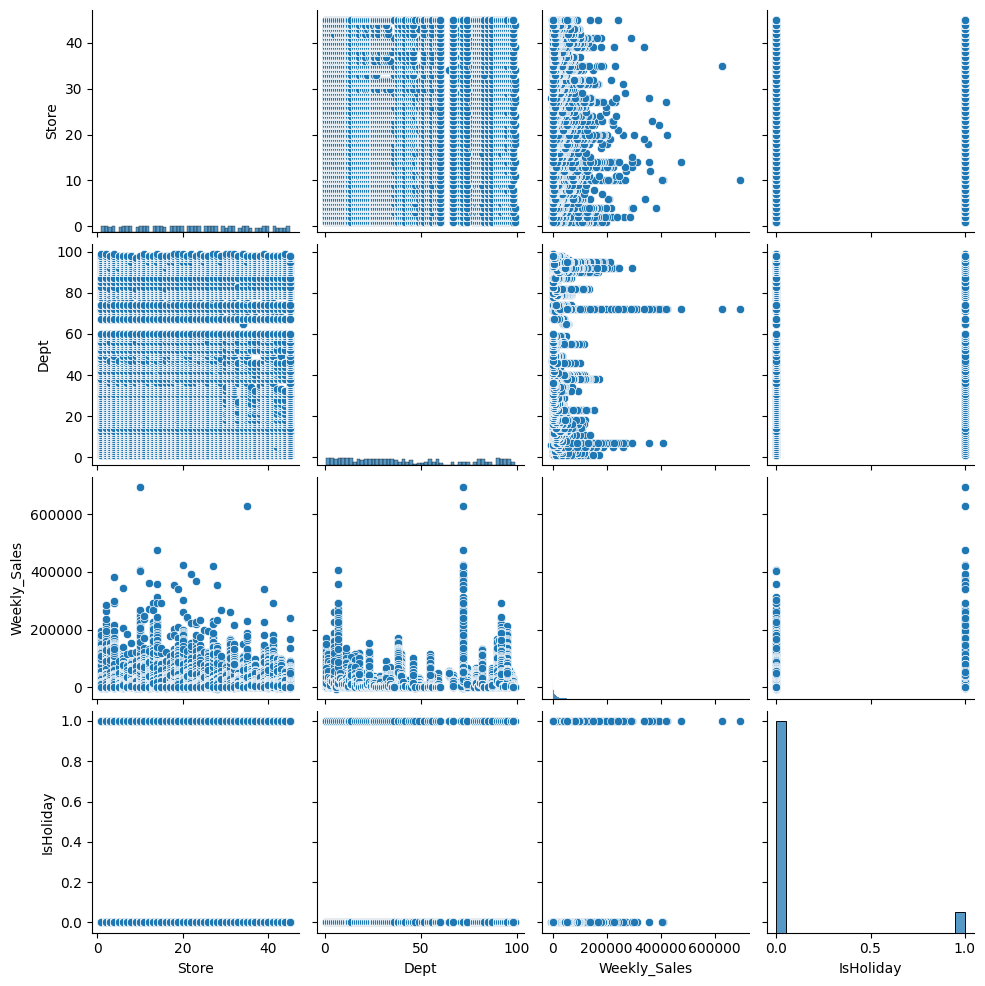

In [ ]:
# sns.pairplot(proj2_data_train)


##Approach I
I began with a simplistic strategy: using the sales data from the most recent week to forecast all subsequent weekly sales. For instance, during the first iteration (t=1), our objective is to forecast sales for March and April of 2011. For every store-department combination, I referenced the sales data from the final week of February 2011 and used it as a basis for predicting sales throughout March and April of 2011.

If any data from that particular week is absent, I substitute the missing values with zeros.

Below is my code for a particular fold.

In [ ]:
num_folds = 10
for i in range(num_folds):
    train = pd.read_csv(f'{path_to_data}/fold_{i+1}/train.csv')
    test = pd.read_csv(f'{path_to_data}/fold_{i+1}/test.csv')

    most_recent_date = train['Date'].max()

    # Filter and select necessary columns
    tmp_train = train[train['Date'] == most_recent_date].copy()
    tmp_train.rename(columns={'Weekly_Sales': 'Weekly_Pred'}, inplace=True)
    tmp_train = tmp_train.drop(columns=['Date', 'IsHoliday'])

    # Left join with the test data
    test_pred = test.merge(tmp_train, on=['Dept', 'Store'], how='left')

    # Fill NaN values with 0 for the Weekly_Pred column
    test_pred['Weekly_Pred'].fillna(0, inplace=True)

    # Write the output to CSV
    test_pred.to_csv(f'{path_to_data}/fold_{i+1}/mypred.csv', index=False)

After running the script in each of the 10 folders, I generated a mypred.csv file in each folder.

Next, I used the following function to calculate the weighted mean absolute error. The same function will be used to evaluate your performance.

Within the function, I first load the complete test data along with the labels. Then, I loop through each of the 10 folds, extracting the corresponding subset based on the test range for that fold, and compute the performance.

In [ ]:
def myeval():
    test_with_label = pd.read_csv(f'{path_to_data}/test_with_label.csv')
    num_folds = 10
    wae = []

    for i in range(num_folds):
        file_path = f'{path_to_data}/fold_{i+1}/test.csv'
        test = pd.read_csv(file_path)
        test = test.drop(columns=['IsHoliday']).merge(test_with_label, on=['Date', 'Store', 'Dept'])

        file_path = f'{path_to_data}/fold_{i+1}/mypred.csv'
        test_pred = pd.read_csv(file_path)
        test_pred = test_pred.drop(columns=['IsHoliday'])

        new_test = test.merge(test_pred, on=['Date', 'Store', 'Dept'], how='left')

        actuals = new_test['Weekly_Sales']
        preds = new_test['Weekly_Pred']
        weights = new_test['IsHoliday'].apply(lambda x: 5 if x else 1)
        wae.append(sum(weights * abs(actuals - preds)) / sum(weights))

    return wae

Below are the errors across 10 folds.



In [ ]:
wae = myeval()
for value in wae:
    print(f"\t{value:.3f}")
print(f"{sum(wae) / len(wae):.3f}")


	2078.726
	2589.338
	2253.936
	2823.098
	5156.012
	4218.348
	2269.904
	2143.839
	2221.145
	2372.425
2812.677


## Approach II
The initial approach did not yield satisfactory results. A closer inspection of the time series plots for various store and department combinations led us to refine our model. Now, for each week we're predicting, we'll leverage data from the corresponding week in the previous year.

By "corresponding week", we introduce a new variable, "Wk", to numerically represent each week of the year, ranging from 1 to 52 (or occasionally 53). For instance, when predicting sales for Week 20 of 2011, we'd consult the data from Week 20 of 2010.

In R, we encountered a misalignment issue: the final week of 2010 is labeled as Week 53, whereas 2011's is Week 52. This discrepancy is particularly problematic since both weeks usually represent the Christmas holidays.

In Python, we are lucky: within our specific time range, each year consistently consists of 52 weeks and the weeks align perfectly:

Wk = 6, Super Bowl
Wk = 36, Labor Day
Wk = 47, Thanksgiving
Wk = 52, Christmas

In [ ]:
date = datetime.strptime("2010-01-01", "%Y-%m-%d") # this is outside our time range
print(date.isocalendar()[1])
date = datetime.strptime("2010-01-04", "%Y-%m-%d")
print(date.isocalendar()[1])
date = datetime.strptime("2010-12-31", "%Y-%m-%d")
print(date.isocalendar()[1])


53
1
52


In [ ]:
date = datetime.strptime("2011-01-07", "%Y-%m-%d")
print(date.isocalendar()[1])
date = datetime.strptime("2011-12-30", "%Y-%m-%d")
print(date.isocalendar()[1])

1
52


In [ ]:
date = datetime.strptime("2012-01-06", "%Y-%m-%d")
print(date.isocalendar()[1])
date = datetime.strptime("2012-12-28", "%Y-%m-%d")
print(date.isocalendar()[1])

1
52


In [ ]:
num_folds = 10
for i in range(num_folds):
    train = pd.read_csv(f'{path_to_data}/fold_{i+1}/train.csv')
    test = pd.read_csv(f'{path_to_data}/fold_{i+1}/test.csv')

    # Define start and end dates based on test data
    start_last_year = pd.to_datetime(test['Date'].min()) - timedelta(days=375)
    end_last_year = pd.to_datetime(test['Date'].max()) - timedelta(days=350)

    # Filter train data based on the defined dates and compute 'Wk' column
    tmp_train = train[(train['Date'] > str(start_last_year))
                      & (train['Date'] < str(end_last_year))].copy()
    tmp_train['Date'] = pd.to_datetime(tmp_train['Date'])
    tmp_train['Wk'] = tmp_train['Date'].dt.isocalendar().week
    tmp_train.rename(columns={'Weekly_Sales': 'Weekly_Pred'}, inplace=True)
    tmp_train.drop(columns=['Date', 'IsHoliday'], inplace=True)

    # Compute 'Wk' column for test data
    test['Date'] = pd.to_datetime(test['Date'])
    test['Wk'] = test['Date'].dt.isocalendar().week

    # Left join with the tmp_train data
    test_pred = test.merge(tmp_train, on=['Dept', 'Store', 'Wk'], how='left').drop(columns=['Wk'])

    # Fill NaN values with 0 for the Weekly_Pred column
    test_pred['Weekly_Pred'].fillna(0, inplace=True)


    # Write the output to CSV
    test_pred.to_csv(f'{path_to_data}/fold_{i+1}/mypred.csv', index=False)

In the implementation, when sourcing data from the corresponding week in the previous year, I didn't precisely offset by 365 days from the test period's start or end. Instead, I slightly expanded the range (subtracting a bit more than 365 days from the starting date and a bit less from the ending date). This adjustment helps to circumvent potential misalignments arising from our week counting method.

Below is the performance.

In [ ]:
wae = myeval()

In [ ]:
for value in wae:
    print(f"\t{value:.3f}")
print(f"{sum(wae) / len(wae):.3f}")

	2262.422
	1787.081
	1779.052
	1716.117
	2400.395
	1696.900
	2086.967
	1750.283
	1719.887
	1680.956
1888.006
